In [1]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image

from models.cnn import ResNet

/home/phuc/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
ep = 4
if (ep+1 == 1 or (ep+1) % 5 == 0):
    print("True")

True


In [3]:
# Check loss per batch of previous trained models
base_dir = "/mnt/beegfs/scratch/phuc/trained_resnets"
run_id = "run-10"
run_dir = os.path.join(base_dir, run_id)

with open(os.path.join(run_dir, "loss.pkl"), "rb") as f:
    logs = pickle.load(f)

train_loss = logs["train_loss"]
val_loss = logs["val_loss"]

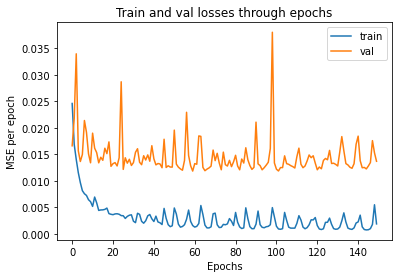

In [7]:
# Train loss and val loss
plt.figure(facecolor="white")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE per epoch")
plt.title("Train and val losses through epochs")
plt.savefig("train-val-err.png")
plt.show()

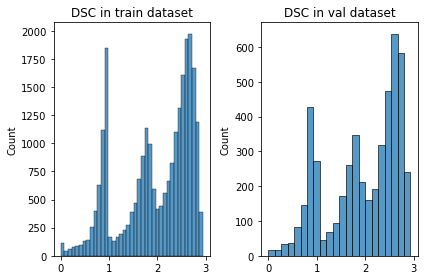

In [2]:
# Visualize the distribution of the training scores
model_id = "model_4"
dice_score_dir = f"/mnt/beegfs/scratch/phuc/seg-quality-control/{model_id}/dices_train.pkl"
val_score_dir = f"/mnt/beegfs/scratch/phuc/seg-quality-control/{model_id}/dices_val.pkl"
with open(dice_score_dir, "rb") as f:
    dices_tr = pickle.load(f)
with open(val_score_dir, "rb") as f:
    dices_vl = pickle.load(f)

fig, axe = plt.subplots(nrows=1, ncols=2)
sns.histplot(ax=axe[0], data=list(dices_tr.values()))
axe[0].set_title("DSC in train dataset")
sns.histplot(ax=axe[1], data=list(dices_vl.values()))
axe[1].set_title("DSC in val dataset")
plt.tight_layout()
plt.show()

In [5]:
# Load a seg map and check for the whole volume of the tumor
model_id = "model_4"
true_seg = f"/mnt/beegfs/scratch/phuc/seg-quality-control/{model_id}/True-segs"
# pred_seg = f"/mnt/beegfs/scratch/phuc/seg-quality-control/{model_id}/dices_val.pkl"

seg_name = "Epoch40_Seg7833.pt"
a = torch.load(os.path.join(true_seg, seg_name))
torch.count_nonzero(a) / torch.numel(a)

tensor(0.0203)

In [11]:
model_id = "model_4"
mri = torch.load(f"/mnt/beegfs/scratch/phuc/seg-quality-control/{model_id}/Ground-truth-images/Epoch100_Img14436.pt")
print(torch.max(mri))
print(torch.min(mri))

tensor(0.7569)
tensor(-1.)
